## DCv2 analysis

Scope:

- Analyze evolution of sum of squared angular distances (SSD) between samples and cluster centers w.r.t training epoch
- Perform analysis for different number of clusters used (e.g. $k = 2, 4, 6, 8, ..., 40$)

Results:

- SSD is lowest for $k = 30$
- SSD increases each epoch, and should eventually saturate and drop again, which is not observed for 800 epochs.


In [2]:
import torch
import pathlib
import numpy as np
import logging
import matplotlib.pyplot as plt
import xarray as xr

import a6
import a6.plotting._colors as _colors


a6.utils.logging.create_logger(
    global_rank=0,
    local_rank=0,
    verbose=False,
)
logger = logging.getLogger("notebook")

device = torch.device("cpu")

plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots/paper-1")

scratch = pathlib.Path("/p/project1/deepacf/emmerich1/dcv2")
path_k40_2_crops = scratch / "multi-level-all-fields-1964-2023"


def get_k_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[-1])


def sort_by_k(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_k_from_file_name(p))


def get_levels_in_data_range(d: xr.DataArray, levels: list) -> list:
    """If a level is not within the data range, `ax.clabel()` fails with:

    `ValueError: sero-zize operation reduction ...`
    
    """
    min_, max_ = d.min(), d.max()
    levels_sub = [level for level in levels if min_ < level < max_]
    return levels_sub


results = sort_by_k(
    scratch.glob("multi-level-all-fields-1964-2023-1200-epochs-k-*")
)
ks = [get_k_from_file_name(p) for p in results]
ks

[2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 34, 38, 40]

## Plot random crop examples

In [3]:
import torchvision

# dataset = torchvision.datasets.CIFAR10(
#     root="/p/project1/deepacf/emmerich1/data/cifar10",
#     train=True,
#     download=True,
# )
dataset = torchvision.datasets.MNIST(
    root="/p/project1/deepacf/emmerich1/data/mnist",
    train=True,
    download=True,
)

In [4]:
# Copied from torchvision package and modified
import math
import numbers
import warnings
from collections.abc import Sequence
from typing import List, Optional, Tuple

import torch
from torch import Tensor

from torchvision.transforms import functional as F
from torchvision.transforms.functional import _interpolation_modes_from_int, InterpolationMode


class RandomResizedCrop(torch.nn.Module):

    def __init__(
        self,
        size,
        scale=(0.08, 1.0),
        ratio=(3.0 / 4.0, 4.0 / 3.0),
        interpolation=InterpolationMode.BILINEAR,
        antialias: Optional[bool] = True,
        return_area: bool = False,
    ):
        super().__init__()
        self.return_area = return_area
        self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")

        if not isinstance(scale, Sequence):
            raise TypeError("Scale should be a sequence")
        if not isinstance(ratio, Sequence):
            raise TypeError("Ratio should be a sequence")
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("Scale and ratio should be of kind (min, max)")

        if isinstance(interpolation, int):
            interpolation = _interpolation_modes_from_int(interpolation)

        self.interpolation = interpolation
        self.antialias = antialias
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img: Tensor, scale: List[float], ratio: List[float]) -> Tuple[int, int, int, int]:
        _, height, width = F.get_dimensions(img)
        area = height * width

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i = torch.randint(0, height - h + 1, size=(1,)).item()
                j = torch.randint(0, width - w + 1, size=(1,)).item()
                return i, j, h, w

        # Fallback to central crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w


    def forward(self, img):
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        crop = F.resized_crop(img, i, j, h, w, self.size, self.interpolation, antialias=self.antialias)
        if self.return_area:
            return (i, j, h, w), crop
        return crop

def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)

    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)
    return size


In [5]:
import torchvision


def create_transform(
    nmb_crops: list[int],
    size_crops: list[float | tuple[float, float]],
    min_scale_crops: list[float],
    max_scale_crops: list[float],
    mean: list[float] | None = None,
    std: list[float] | None = None,
    to_tensor: bool = False,
    return_area: bool = False,
):
    return [
        # Define transform pipeline
        torchvision.transforms.Compose(
            list(
                filter(
                    None,
                    [
                        # torchvision.transforms.PILToTensor(),
                        RandomResizedCrop(
                            size,
                            scale=(min_scale, max_scale),
                            antialias=True,
                            return_area=return_area,
                        ),
                        ###
                        (
                            torchvision.transforms.ToTensor()
                            if to_tensor
                            else None
                        ),
                        # torchvision.transforms.Normalize(mean=mean, std=std),
                    ],
                )
            )
        )
        for n_crops, size, min_scale, max_scale in zip(
            nmb_crops, size_crops, min_scale_crops, max_scale_crops, strict=True
        )
        # Repeat transform for `n_crops` to achieve the given number of crops
        for _ in range(n_crops)
    ]

RANK 0 (LOCAL 0) - WARNING - 2024-10-10 16:58:32 - 0:00:00 - Converted relative crop sizes ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)) to absolute crop sizes [(28, 28), (28, 28), (11, 11)]


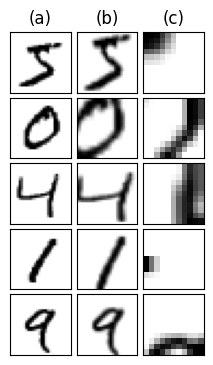

In [6]:
sample = np.array(dataset[0][0])
absolute_sizes = a6.datasets.crop.convert_relative_to_absolute_crop_size(
    ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)),
    size_x=sample.shape[0],
    size_y=sample.shape[1],
)
transforms = create_transform(
    nmb_crops=(1, 1, 1),
    size_crops=absolute_sizes,
    min_scale_crops=(1.0, 0.14, 0.05),
    max_scale_crops=(1.0, 1.0, 0.14),
    to_tensor=True,
)
n_images = 5
n_crops = 3
fig, axs = plt.subplots(
    figsize=(0.75 * n_crops, 0.75 * n_images), nrows=n_images, ncols=n_crops
)

for i in range(n_images):
    image, label = dataset[i]
    crops = [trans(image) for trans in transforms]
    row = axs[i]

    for j, crop in enumerate(crops):
        ax = row[j]
        if i == 0:
            if j == 0:
                label = "a"
            elif j == 1:
                label = "b"
            elif j == 2:
                label = "c"

            ax.set_title(f"({label})")

        # ax.set_title(f"{label}")
        # print(crop.permute(1, 2, 0).shape)

        ax.imshow(torchvision.transforms.ToPILImage()(crop), cmap="gray_r")

        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])


fig.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.savefig(plots / "figB1.pdf")

In [7]:
import random
import xarray as xr

coordinates = a6.datasets.coordinates.Coordinates()
variables = a6.datasets.variables.Model()

level = 500

ds = xr.open_dataset(
    "/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12.nc"
)

random_indexes = sorted(random.sample(list(range(ds.time.size)), 3))
print(random_indexes)

ds_sub = (
    a6.features.methods.geopotential.calculate_geopotential_height(
        variables=variables,
    )
    >> a6.features.methods.wind.calculate_wind_speed(
        variables=variables,
    )
    >> a6.datasets.methods.select.select_variables(
        variables=[
            variables.geopotential_height,
            variables.t,
        ]
    )
).apply_to(ds.isel(time=random_indexes))

[6597, 17424, 18984]


In [8]:
absolute_sizes = a6.datasets.crop.convert_relative_to_absolute_crop_size(
    ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)),
    size_x=ds[coordinates.latitude].size,
    size_y=ds[coordinates.longitude].size,
)

transforms = create_transform(
    nmb_crops=(1, 1, 1),
    size_crops=absolute_sizes,
    min_scale_crops=(1.0, 0.14, 0.05),
    max_scale_crops=(1.0, 1.0, 0.14),
    return_area=True,
)

images = [
    a6.datasets.transforms.xarray.concatenate_levels_to_channels(
        ds_sub,
        time_index=i,
        levels=[level],
        coordinates=coordinates,
    )
    for i, _ in enumerate(random_indexes)
]

multi_crops = [
    list(map(lambda trans: trans(image), transforms))
    for image in images
]
print(multi_crops[0][0][1].shape)

max_val_t = max(image[1].max() for image in images)
min_val_t = min(image[1].min() for image in images)
min_val_t, max_val_t

RANK 0 (LOCAL 0) - WARNING - 2024-10-10 16:58:36 - 0:00:05 - Converted relative crop sizes ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)) to absolute crop sizes [(141, 221), (141, 221), (56, 88)]


torch.Size([2, 141, 221])


(tensor(232.2776), tensor(266.6102))

In [12]:
import datetime

time = ds_sub.isel(time=0).time.values

dt = datetime.datetime.strptime(str(time)[:10], "%Y-%m-%d", )
dt.strftime("%d %B %Y")

'23 January 1982'

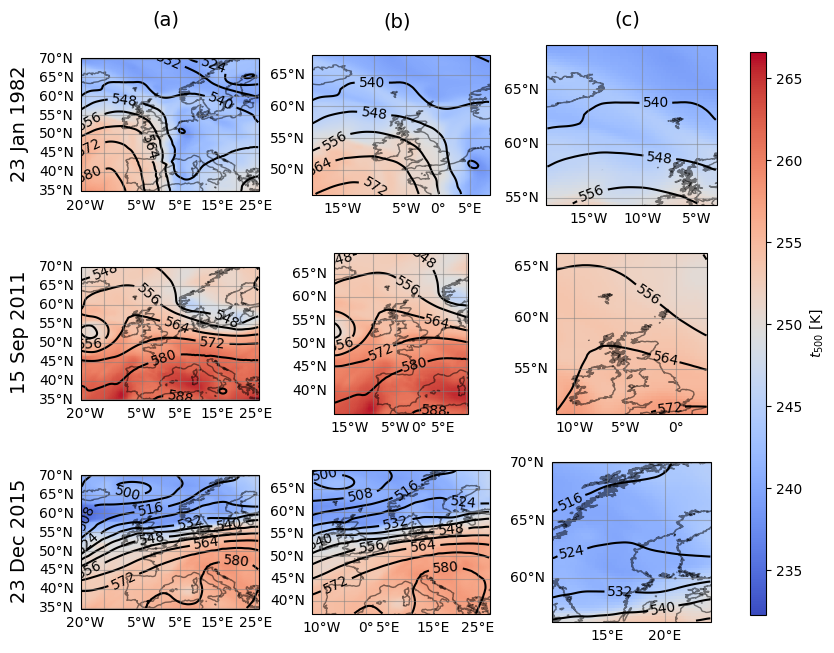

In [25]:
%matplotlib inline
import datetime
import cartopy.crs as ccrs
import matplotlib.patches as patches

nrows = len(images)
ncols = len(multi_crops)

z_h_steps = 8 # 4dam steps used by ECMWF
levels = list(range(500, 600, z_h_steps))

height = nrows * 2.5
width = ncols * 2.75

fig, axs = plt.subplots(
    figsize=(width, height),
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for col in range(ncols):
    for row in range(nrows):
        ax = axs[row][col]

    
        # Create Dataset with the cropped area
        (i, j, h, w), image = multi_crops[row][col]
        lat_idx = slice(i, i + h)
        lon_idx = slice(j, j + w)
        time = ds_sub.isel(time=row).time.values

        # Get lat-lon area of crop
        latitudes = ds_sub.latitude[lat_idx]
        longitudes = ds_sub.longitude[lon_idx]

        # Create new lat-lon coordinates with size of crop
        new_latitudes = np.linspace(latitudes.max(), latitudes.min(), image[0].size(0))
        new_longitudes = np.linspace(longitudes.min(), longitudes.max(), image[0].size(1))

        area = xr.Dataset(
            data_vars={
                "z_h": (("latitude", "longitude"), image[0]),
                "t": (("latitude", "longitude"), image[1]),
            },
            coords={
                coordinates.latitude: (coordinates.latitude, new_latitudes),
                coordinates.longitude: (coordinates.longitude, new_longitudes),
            }
        )

        heatmap = area.t.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="coolwarm",
            vmin=min_val_t,
            vmax=max_val_t,
            add_colorbar=False,
        )

        levels_sub = get_levels_in_data_range(area.z_h, levels=levels)
        contours = area.z_h.plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels_sub,
            colors=["black"],
        )

        ax.clabel(
            contours,
            inline=True,
            fontsize=10,
            colors=['black'],
            fmt='%i',
        )

        ax.coastlines(alpha=0.5)

        grid_kwargs = dict(
            crs=ccrs.PlateCarree(),
            color="gray",
            alpha=0.5,
            xlabel_style={"rotation": 0},
            xlocs=list(range(-20, 30, 5)),
            ylocs=list(range(35, 75, 5)),
            # linestyle="--",
        )
        ax.gridlines(draw_labels=["left", "bottom"], **grid_kwargs)

        # notations for date and column enumeration
        fontsize = 14

        if col == 0:
            dt = datetime.datetime.strptime(str(time)[:10], "%Y-%m-%d", )
            as_str = dt.strftime("%d %b %Y")
            if row == 0:
                xy = (-0.4, 0.1)
            elif row == 1:
                xy = (-0.4, 0.075)
            else:
                xy = (-0.4, 0.075)
            ax.annotate(
                as_str,
                xy=xy,
                xycoords="axes fraction",
                fontsize=fontsize,
                rotation=90
            )

        enumeration_kwargs = dict(
        )
        if row == 0:
            if col == 0:
                ax.annotate(
                    "(a)",
                    xy=(0.4, 1.25),
                    xycoords="axes fraction",
                    fontsize=fontsize,
                )
            elif col == 1:
                ax.annotate(
                    "(b)",
                    xy=(0.4, 1.2),
                    xycoords="axes fraction",
                    fontsize=fontsize,
                )
            elif col == 2:
                ax.annotate(
                    "(c)",
                    xy=(0.4, 1.12),
                    xycoords="axes fraction",
                    fontsize=fontsize,
                )

pos_top = axs[0][-1].get_position()

ax_cbar = fig.add_axes([pos_top.x1 + 0.04, 0.12, 0.02, 0.75]) # left, bottom, width, height
cbar = fig.colorbar(
    heatmap,
    cax=ax_cbar,
    orientation="vertical",
    label=rf"$t_{{{level}}}$ [K]",
)

# fig.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig(plots / "fig01.png", dpi=300, bbox_inches="tight")

In [ ]:

import matplotlib.patches as patches


def format_tick(v) -> str:
    if v.values == 0:
        return "$0^{{\circ}}$"
    elif v.values < 0:
        return f"${abs(v.values):.0f}^{{\circ}}\,\mathrm{{W}}$"
    else:
        return f"${v.values:.0f}^{{\circ}}\,\mathrm{{E}}$"


# Columns are the crops of different sizes
ncols = len(multi_crops)
# Rows are the different variables
nrows = multi_crops[0].shape[0]

fig, axs = plt.subplots(
    figsize=(2 * ncols, 1.3 * nrows),
    nrows=nrows,
    ncols=ncols,
    gridspec_kw={"width_ratios": [0.8, 0.8, 1]},
)
grid = axs.flatten()

cmaps = ["cool", "coolwarm", "cividis", "turbo", "turbo"]


for i, data in enumerate(panels):
    vmin, vmax = mins[i // ncols], maxs[i // ncols]
    field_name = field_names[i // ncols]
    ax = grid[i]
    im = ax.imshow(
        data,
        vmin=vmin,
        vmax=vmax,
        cmap=cmaps[i // ncols],
        aspect="auto",
        interpolation="nearest",
    )

    if i in list(range(2, 99, 3)):
        cbar = plt.colorbar(im, aspect=10)
        cbar.set_label(field_name)

    if i in list(range(0, 99, 3)):
        old_xticks = ax.get_xticks()
        new_xticks = np.arange(20, len(ds[coordinates.longitude]), 40)
        new_xticklabels = [
            format_tick(v) for v in ds[coordinates.longitude][new_xticks]
        ]
        ax.set_xticks(new_xticks)

        x, y = (110, 2)
        width = 90
        height = 65
        color = "black"
        rect_kwargs = dict(
            linewidth=1, linestyle=":", edgecolor=color, facecolor="none"
        )
        rect = patches.Rectangle((x, y), width, height, **rect_kwargs)
        ax.add_patch(rect)
        ax.text(x + (width / 2) - 20, y + (height / 2), "(c)", color=color)

        x, y = (5, 55)
        width = 115
        height = 83
        rect = patches.Rectangle((x, y), width, height, **rect_kwargs)
        ax.add_patch(rect)
        ax.text(x + (width / 2) - 15, y + (height / 2) + 10, "(b)", color=color)

        # only draw xticklabels for lower left plot
        if i == 12:
            pass
            ax.set_xticklabels(new_xticklabels, rotation=45, fontsize=9)
        else:
            pass
            ax.set_xticklabels([])

        old_yticks = ax.get_yticks()
        new_yticks = np.arange(20, len(ds[coordinates.latitude]), 40)
        new_yticklabels = [
            f"${v.values:.0f}^{{\circ}}\,\mathrm{{N}}$"
            for v in ds[coordinates.latitude][new_yticks]
        ]
        ax.set_yticks(new_yticks)
        ax.set_yticklabels(new_yticklabels, fontsize=9)
    else:
        ax.set_xticks([])
        ax.set_yticks([])

    if i == 0:
        ax.set_title("(a)")
    elif i == 1:
        ax.set_title("(b)")
    elif i == 2:
        ax.set_title("(c)")

    if i in [0, 1, 2]:
        contours = ax.contour(
            data, list(range(0, int(vmax) + 8, 8)), colors="k", origin="lower"
        )
        ax.clabel(contours, contours.levels, inline=True, fontsize=9)

fig.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.savefig(plots / "fig01.pdf", bbox_inches="tight")

In [5]:
import torch.nn as nn
import sklearn.metrics
import itertools


def get_epoch_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[1])


def sort_by_epoch(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_epoch_from_file_name(p))


def calculate_ssds_with_mean_and_std(path: pathlib.Path) -> torch.Tensor:
    """Get the sum of squared (angular) distances between samples and cluster centers."""
    tensors_path = path
    distance_files = sort_by_epoch(tensors_path.glob("*-distances.pt"))
    centroids_files = sort_by_epoch(tensors_path.glob("*-centroids.pt"))
    embeddings_files = sort_by_epoch(tensors_path.glob("*-embeddings.pt"))
    assignments_files = sort_by_epoch(tensors_path.glob("*-assignments.pt"))

    device = torch.device("cpu")
    distances = [
        torch.load(file, map_location=device) for file in distance_files
    ]
    embeddings = [
        torch.load(file, map_location=device) for file in embeddings_files
    ]
    centroids = [
        torch.load(file, map_location=device) for file in centroids_files
    ]
    assignments = [
        torch.load(file, map_location=device) for file in assignments_files
    ]
    epochs = [get_epoch_from_file_name(file) for file in distance_files]

    logger.info("%s was chechpointed at epochs %s", path.as_posix(), epochs)

    def calculate_ssd(e: torch.Tensor, c: torch.Tensor) -> float:
        """Calculate the sum of squared angular distance (cosine distance = 1 - cosine similarity)."""
        head = -1
        crop = 1
        dot_products = torch.mm(e[head][crop], c.t())
        cos_sim, _ = dot_products.max(dim=1)
        return ((1 - cos_sim) ** 2).sum()

    ssd_per_head = [calculate_ssd(e, c) for e, c in zip(embeddings, centroids)]
    ssd_mean = [ssd.nanmean() for ssd in ssd_per_head]
    ssd_std = [ssd.std() for ssd in ssd_per_head]

    return epochs, ssd_per_head, ssd_mean, ssd_std


ssds_six_crops = {
    k: calculate_ssds_with_mean_and_std(p)
    for k, p in zip(ks, results, strict=True)
}

RANK 0 (LOCAL 0) - INFO - 2024-10-02 15:32:28 - 0:11:10 - /p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-2 was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]
/tmp/ipykernel_777/306572849.py:49: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]
RANK 0 (LOCAL 0) - INFO - 2024-10-02 15:32:32 - 0:11:14 - /p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-4 was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]
RANK 0 (LOCAL 0) - INFO - 2024-10-02 15:32:36 - 0:11:18 - /p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-202

In [6]:
def plot_ssds(
    ssds_results, manual_scale_axis: bool = False, plot_individual: bool = False
):
    colors = iter(_colors.create_colors_for_labels(ks))

    ncols = 4 if plot_individual else 1
    nrows = (len(ssds_results) // 4) + 1 if plot_individual else 1

    fig, axs = plt.subplots(
        figsize=(6 * ncols, 4 * nrows),
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=True,
    )

    for i, (k, (epochs, ssd_per_head, ssd_mean, ssd_std)) in enumerate(
        ssds_results.items()
    ):
        ax = axs.flatten()[i] if plot_individual else axs

        # if k == 2:
        #     # k = 2 is extremely different and actually has a declining SSD curve
        #     continue

        # ax.plot(epochs, ssd_mean, label=rf"${k=}$", c=next(colors))
        ax.errorbar(epochs, ssd_mean, ssd_std, label=rf"${k=}$", c=next(colors))

        # For individual plots, put title instead of legend
        if plot_individual:
            ax.set_title(rf"${k=}$")

        if manual_scale_axis:
            ax.set_ylim(5e9, 2e10)
            ax.set_xlim(0, 1100)

        ax.set(yscale="log")
        ax.axvline(24, 0, 1e5)

    # For single plot, put legend
    if not plot_individual:
        fig.legend(ncol=3, bbox_to_anchor=(1, 1), loc="upper right")

    # plt.savefig(plots / "scree-test-dcv2-ssds.pdf", bbox_inches="tight")


# plot_ssds(ssds_six_crops, manual_scale_axis=False, plot_individual=False)

RANK 0 (LOCAL 0) - INFO - 2024-09-04 11:12:06 - 0:01:37 - /p/project1/deepacf/emmerich1/dcv2/mnist-1-node-1-gpu was chechpointed at epochs [0, 24, 49, 74, 99, 199, 299, 399, 499, 599, 699, 799]
/tmp/ipykernel_18843/1133842414.py:40: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]


[0, 24, 49, 74, 99, 199, 299, 399, 499, 599, 699, 799]


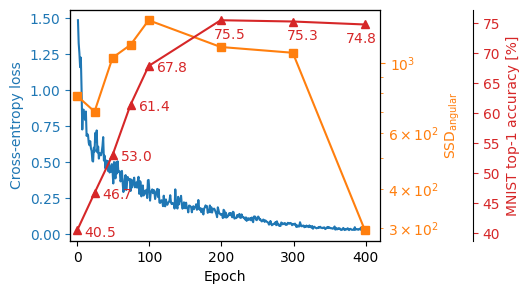

In [7]:
import pandas as pd

path_mnist = pathlib.Path(
    "/p/project1/deepacf/emmerich1/dcv2/mnist-1-node-1-gpu"
)
# Training was interrupted at epoch 439 and restarted,
# hence the metrics should only be considered from there
start = 440
end = start + 399

fig, ax = plt.subplots(figsize=(4, 3))

ax.set_xlabel("Epoch")

metrics_0 = pd.read_csv(path_mnist / "stats-rank-0.csv")

epochs = metrics_0["epoch"].iloc[start:end]
loss = metrics_0["loss"].iloc[start:end]
epochs = np.arange(1, len(loss) + 1)

ax_color = "tab:blue"

ax.plot(epochs, loss, color=ax_color)

ax.set_ylabel("Cross-entropy loss", color=ax_color)

# Plot cumulative variance on first axis
ax_color = "tab:blue"

# Create right axis.
ax_right = ax.twinx()

epochs, _, ssd_mean, _ = calculate_ssds_with_mean_and_std(path_mnist)
print(epochs)


# Plot the explained variance ratios.
ax_right_color = "tab:orange"
ax_right.set_ylabel("SSD$_{\mathrm{angular}}$", color=ax_right_color)
ax_right.plot(
    epochs[:8],
    ssd_mean[:8],
    color=ax_right_color,
    # linestyle="--",
    label="",
    marker="s",
)

acc = {
    0: 0.4049333333969116,
    24: 0.46700000762939453,
    49: 0.5301666855812073,
    74: 0.614133358001709,
    99: 0.6783833503723145,
    199: 0.7546833157539368,
    299: 0.7525500059127808,
    399: 0.7475833296775818,
}

ax_acc_color = "tab:red"

ax_acc = ax.twinx()
ax_acc.spines.right.set_position(("axes", 1.3))

x = list(acc.keys())
y = np.array(list(acc.values())) * 100

ax_acc.plot(
    x,
    y,
    color=ax_acc_color,
    marker="^",
    # linestyle="-.",
)
ax_acc.set_ylabel("MNIST top-1 accuracy [%]", color=ax_acc_color)


# loop through each x,y pair
for i, j in zip(x, y):
    if i < 199:
        xy = (i + 10, j - 1)
    elif i == 399:
        xy = (i - 28, j - 3)
    else:
        xy = (i - 10, j - 3)
    ax_acc.annotate(f"${j:.1f}$", xy=xy, color=ax_acc_color)


for ax, color, log_scale_y in [
    (ax, ax_color, False),
    (ax_right, ax_right_color, True),
    (ax_acc, ax_acc_color, False),
]:
    # Set log scale.
    if log_scale_y:
        ax.set(yscale="log")
    # Set left xlim such that the first tick disappears.
    ax.set_xlim(-10, 420)
    # Color the ticks.
    ax.tick_params(axis="y", colors=color, which="both")


plt.savefig(plots / "figB2.pdf", bbox_inches="tight")

In [8]:
epoch_index = 20
print([epochs[epoch_index] for epochs, _, _, _ in ssds_six_crops.values()])

[799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799]


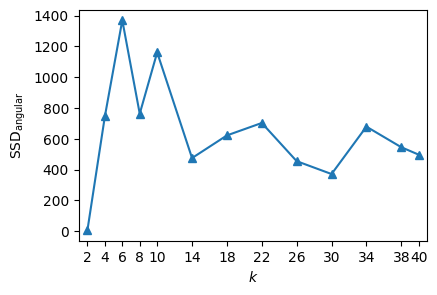

In [9]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(
    figsize=(4.5 * ncols, 3 * nrows),
    nrows=nrows,
    ncols=ncols,
    sharex=False,
    sharey=False,
)

colors = iter(_colors.create_colors_for_labels(ks))

x = list(ssds_six_crops.keys())
y = list(ssd_mean[epoch_index] for _, _, ssd_mean, _ in ssds_six_crops.values())

ax.plot(
    x,
    y,
    marker="^",
)

# Elbow
# x_line = [4, 14]
# y_line = [1300, 600]
# ax.plot(x_line, y_line, c="gray", linestyle="--")
# x_line = [14, 42]
# y_line = [600, 500]
# ax.plot(x_line, y_line, c="gray", linestyle="--")

ax.set(
    xlabel="$k$",
    xticks=x,
    xticklabels=x,
    ylabel="$\mathrm{SSD}_{\mathrm{angular}}$",
    # yscale="log",
    # ylim=(0, 1400),
    xlim=(1, 41),
)

plt.savefig(plots / "fig03.pdf", bbox_inches="tight")

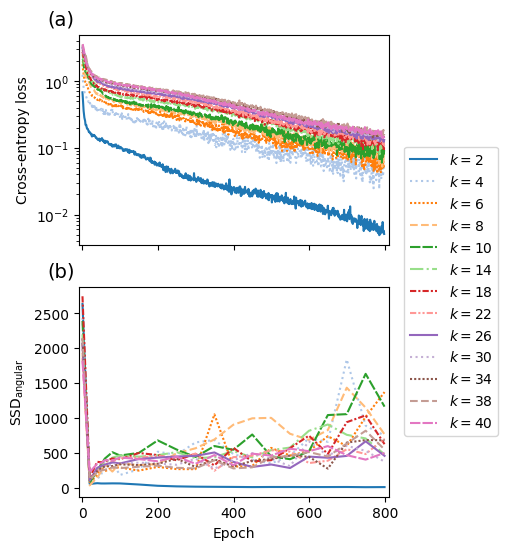

In [27]:
import pandas as pd
import matplotlib.cm
import matplotlib.lines
import itertools
from collections import OrderedDict

colors = matplotlib.cm.tab20(range(20))
markers = list(matplotlib.lines.Line2D.markers.keys())

def get_linestyles():
    return itertools.cycle(
        [
            "solid",
            "dotted",
            (0, (1, 1)), # densely dotted
            "dashed",
            (0, (5, 1)), # densely dashed
            "dashdot",
            (0, (3, 1, 1, 1)), # densely dash-dotted
            (0, (3, 1, 1, 1, 1, 1)), # densely dash-dot-dotted
        ]
    )

fig, axs = plt.subplots(figsize=(4, 6), ncols=1, nrows=2, sharex=True)

ax = axs[0]

linestyles = get_linestyles()

for i, path in enumerate(results):
    metrics_0 = pd.read_csv(path / "stats-rank-0.csv")

    epochs = metrics_0["epoch"].iloc[:799]
    loss = metrics_0["loss"].iloc[:799]

    ax.plot(
        epochs, 
        loss,
        label=rf"$k={get_k_from_file_name(path)}$",
        c=colors[i],
        # marker=markers[i],
        linestyle=next(linestyles),
        # markevery=25,
    )

ax.set(
    xlim=(-10, 810),
    ylabel="Cross-entropy loss",
    # title="(a)",
    yscale="log",
)

ax.annotate(
    "(a)",
    xy=(-0.1, 1.05),
    xycoords="axes fraction",
    fontsize=14,
)

ax.legend(ncol=1, bbox_to_anchor=(1.375, 0.5), loc="upper right")


ax = axs[1]

linestyles = get_linestyles()

for i, (k, (epochs, ssd_per_head, ssd_mean, ssd_std)) in enumerate(
    ssds_six_crops.items()
):
    # if k == 2:
    #     # k = 2 is extremely different and actually has a declining SSD curve
    #     continue

    ax.plot(
        epochs[: epoch_index + 1],
        ssd_mean[: epoch_index + 1],
        label=rf"${k=}$",
        c=colors[i],
        # marker=markers[i],
        # markevery=2,
        linestyle=next(linestyles),
    )
    # ax.errorbar(epochs, ssd_mean, ssd_std, label=rf"${k=}$", c=next(colors))

ax.set(
    xlabel="Epoch",
    ylabel="$\mathrm{SSD}_{\mathrm{angular}}$",
    # yscale="log",
    # title="(b)",
)
ax.annotate(
    "(b)",
    xy=(-0.1, 1.05),
    xycoords="axes fraction",
    fontsize=14,
)

# plt.legend(ncols=3)

plt.savefig(plots / "fig02.pdf", bbox_inches="tight")